In [ ]:
import pandas as pd
import numpy as np
from keras.callbacks import TensorBoard
import tensorflow as tf

import keras
from keras import layers
import os
import cv2
import json
import glob
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#=============use this for dataset comparison
X=np.load("/content/drive/My Drive/cs330_dataset/fine_tune_x.npy")
X2=np.load("/content/drive/My Drive/cs330_dataset/x9.npy")


def suffle_and_split(X,sample=1000):
    max_len=X.shape[0]
    X_f=X.reshape(X.shape[0],-1)
    r=np.random.permutation(max_len)
    X_shuffle=X_f[r,:]
    X_sample=X_shuffle[0:sample,]
    return X_sample

X_sample1=suffle_and_split(X,sample=10000)
X_sample2=suffle_and_split(X2,sample=10000)
print(X_sample2.shape)

X_sample1=np.squeeze(X_sample1.reshape(1,-1))
X_sample2=np.squeeze(X_sample2.reshape(1,-1))

from scipy.stats import skew,kurtosis

def matrix(a,b):
  a_skew=skew(a, axis=0, bias=True)
  b_skew=skew(b, axis=0, bias=True)
  a_curtosi=kurtosis(a, axis=0, bias=True)
  b_curtosi=kurtosis(b, axis=0, bias=True)
  matrix=np.sqrt((np.abs(a_skew)-np.abs(b_skew))**2+(np.abs(a_curtosi)-np.abs(b_curtosi))**2+(np.mean(a)-np.mean(b))**2)
  mean=np.sqrt((np.mean(a)-np.mean(b))**2)
  return matrix,mean

# print(">>>>target mean",np.mean(X_sample1))
# print(skew(X_sample1, axis=0, bias=True))
# print(kurtosis(X_sample1, axis=0, bias=True))

# print(">>>>target mean",np.mean(X_sample2))
# print(skew(X_sample2, axis=0, bias=True))
# print(kurtosis(X_sample2, axis=0, bias=True))

matri,mean=matrix(X_sample1,X_sample2)
print(matri)

(1594, 2352)
0.6112457814004826


In [ ]:
#==========ks statistics
from scipy.stats import ks_2samp
from sklearn.metrics import mutual_info_score
  


kl2=mutual_info_score(X_sample1, X_sample2)
print(kl2)

#========ks statstics
ks_2samp(X_sample1, X_sample2,alternative='two-sided')


0.16381403023868646


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/cluster/_supervised.py:65: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)


KstestResult(statistic=0.14805697278911567, pvalue=0.0)

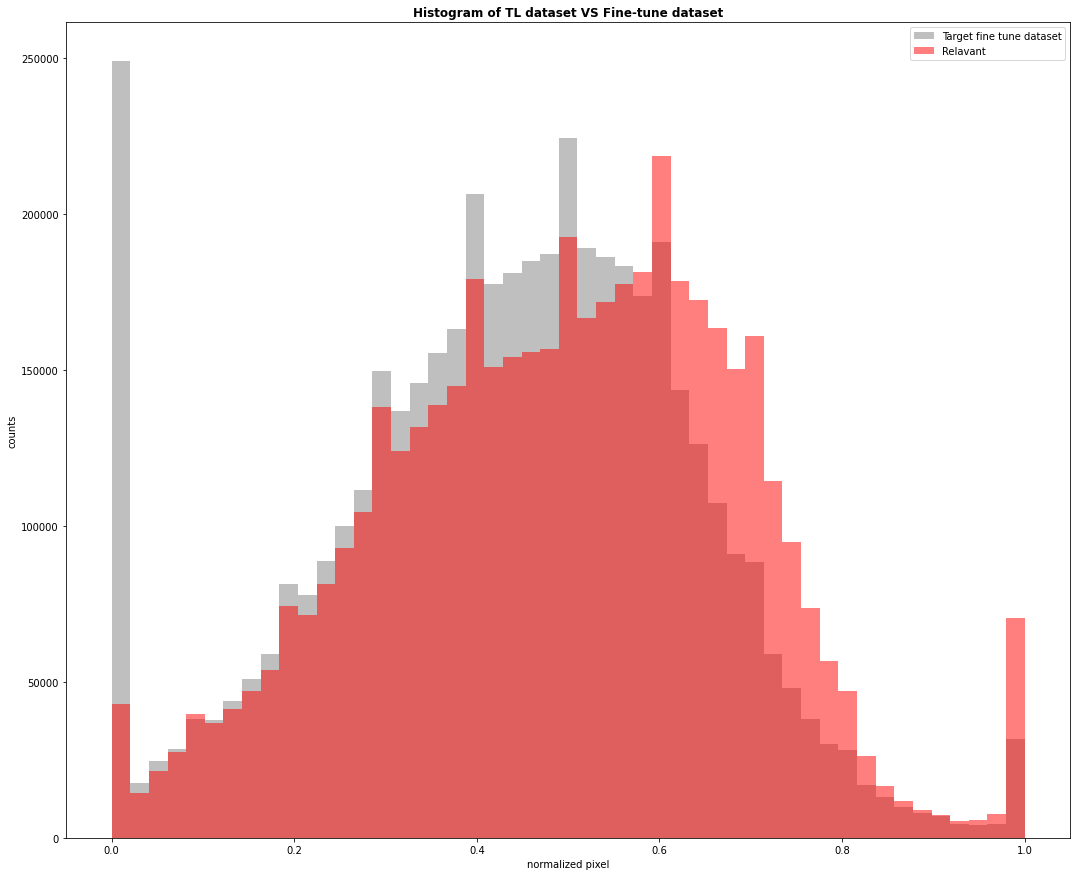

In [ ]:
#==============use this to plot grpah for dataset
plt.figure(figsize=(18,15))
bins = np.linspace(0, 1, 50)
# plotting first histogram
plt.hist(X_sample1,bins, label='Target fine tune dataset', alpha=.5,color="gray")
 
# plotting second histogram
plt.hist(X_sample2,bins, label='Relavant', alpha=0.5,color="red")
plt.legend()
plt.title('Histogram of TL dataset VS Fine-tune dataset',
          fontweight ="bold")
plt.xlabel('normalized pixel')
plt.ylabel('counts')
 
# Showing t
plt.show()


In [ ]:
from scipy import stats
loc_param, scale_param = stats.norm.fit(X_sample1)
print(loc_param)
print(scale_param)
loc_param2, scale_param2 = stats.norm.fit(X_sample2)
print(loc_param2)
print(scale_param2)

print(">>>>loc_diff",loc_param-loc_param2)
print(">>>>scale_diff",scale_param-scale_param2)

0.43857405
0.19299795
0.49335572
0.21240525
>>>>loc_diff -0.054781675
>>>>scale_diff -0.019407302


In [ ]:
#==================Use this part for weight matrix

class Bas_Conv2D(tf.keras.Model):
    def __init__(self, filters, kernel_size, strides,padding):
        super().__init__()
        self.conv = tf.keras.layers.Conv2D(filters=filters,
                                           kernel_size=kernel_size,
                                           strides=strides,
                                           padding=padding)
        self.bn = tf.keras.layers.BatchNormalization()
        self.relu = tf.keras.layers.ReLU()

    def call(self, inputs):
        output = self.conv(inputs)
        output = self.bn(output)
        output = self.relu(output)

        return output


class Model_transfer(tf.keras.Model):
    def __init__(self):
        super().__init__()

        self.layer1 = Bas_Conv2D(filters=64,
                                 kernel_size=(3, 3),
                                 strides=2,padding='valid')

        self.layer2 = Bas_Conv2D(filters=128,
                                 kernel_size=(3, 3),
                                 strides=2,padding='valid')

        self.layer3 = Bas_Conv2D(filters=128,
                                 kernel_size=(3, 3),
                                 strides=2,padding='valid')

        self.pooling = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))

        self.flatten = tf.keras.layers.Flatten()
        
        self.dropout = tf.keras.layers.Dropout(rate=0.3)

        self.dense = tf.keras.layers.Dense(units=10, activation="softmax")

    def call(self, inputs,training=None):

        x = self.layer1(inputs)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.pooling(x)
        x = self.flatten(x)
        x = self.dropout(x, training=training)
        output=self.dense(x)
        return output


def get_weight_layer(fine_tune_weights):
    fine_tune_weights=fine_tune_weights


    learning_rate=0.001
    base_model=Model_transfer()
    checkpoint = tf.train.Checkpoint(base_model)
    checkpoint.restore(fine_tune_weights).expect_partial()


    opt=tf.keras.optimizers.Adam(learning_rate=learning_rate)
    base_model.compile(optimizer=opt,loss="categorical_crossentropy",metrics=["categorical_accuracy"])
    base_model.build(input_shape=(None,28,28,3))

    for layer in base_model.layers[2:3]:
        # print(layer.name)
        weights=layer.get_weights()[0]
        weigth_np=np.array(weights,dtype=object)
        weigth_np_b=np.swapaxes(weigth_np,3,0)
        weigth_np_r=np.reshape(weigth_np_b,(weigth_np_b.shape[0],weigth_np_b.shape[1]*weigth_np_b.shape[2]*weigth_np_b.shape[3]))

    return weigth_np_r

path1="/content/drive/My Drive/cs330_dataset/model2_tl"
path2="/content/drive/My Drive/cs330_dataset/model2"

weight_model1=get_weight_layer(path1)
weight_model_fine=get_weight_layer(path2)

weight1_mean=np.mean(np.squeeze(weight_model1))
weight_fine_mean=np.mean(np.squeeze(weight_model_fine))

weight_tl_var=np.var(np.squeeze(weight_model1))
weight_fine_var=np.var(np.squeeze(weight_model_fine))


X_tune=np.squeeze(weight_model_fine.reshape(1,-1))
X_tl=np.squeeze(weight_model1.reshape(1,-1))

#==========ks statistics
from scipy.stats import ks_2samp
from sklearn.metrics import mutual_info_score

kl2=mutual_info_score(X_tune, X_tl)
print("ks statistics",kl2)

#========ks statstics
ks_2samp(X_tune, X_tl,alternative='two-sided')

ks statistics 11.88729917131539


KstestResult(statistic=0.06925455729166663, pvalue=6.436604669383864e-308)

In [ ]:
#=============for weight matrix
bins = np.linspace(-0.1, 0.1, 100)
# plotting first histogram
plt.hist(X_tl,bins,label='Transfer Model weight', alpha=0.5)
plt.hist(X_tune,bins, label='Fine-tune weight', alpha=0.3)
plt.legend()
plt.title('Histogram of trained weights - NOT Relavant',
          fontweight ="bold")
plt.xlabel('weights matrix')
plt.ylabel('counts')
 
# Showing t
plt.show()

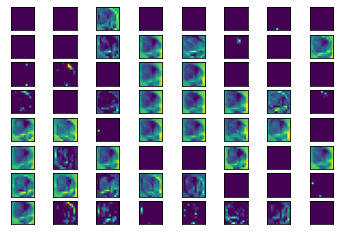

In [ ]:
#==============featrue maps
def get_model_feature(path_weight,data_path,sample):
  class Bas_Conv2D(tf.keras.Model):
      def __init__(self, filters, kernel_size, strides,padding):
          super().__init__()
          self.conv = tf.keras.layers.Conv2D(filters=filters,
                                            kernel_size=kernel_size,
                                            strides=strides,
                                            padding=padding)
          self.bn = tf.keras.layers.BatchNormalization()
          self.relu = tf.keras.layers.ReLU()

      def call(self, inputs):
          output = self.conv(inputs)
          output = self.bn(output)
          output = self.relu(output)

          return output


  class Model_transfer(tf.keras.Model):
      def __init__(self):
          super().__init__()

          self.layer1 = Bas_Conv2D(filters=64,
                                  kernel_size=(3, 3),
                                  strides=2,padding='valid')

          self.layer2 = Bas_Conv2D(filters=128,
                                  kernel_size=(3, 3),
                                  strides=2,padding='valid')

          self.layer3 = Bas_Conv2D(filters=128,
                                  kernel_size=(3, 3),
                                  strides=2,padding='valid')

          self.pooling = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))

          self.flatten = tf.keras.layers.Flatten()
          
          self.dropout = tf.keras.layers.Dropout(rate=0.3)

          self.dense = tf.keras.layers.Dense(units=10, activation="softmax")

      def call(self, inputs,training=None):

          x = self.layer1(inputs)
          x = self.layer2(x)
          x = self.layer3(x)
          x = self.pooling(x)
          x = self.flatten(x)
          x = self.dropout(x, training=training)
          output=self.dense(x)
          return output

  learning_rate=0.001
  base_model=Model_transfer()
  checkpoint = tf.train.Checkpoint(base_model)
  checkpoint.restore(path_weight).expect_partial()


  opt=tf.keras.optimizers.Adam(learning_rate=learning_rate)
  base_model.compile(optimizer=opt,loss="categorical_crossentropy",metrics=["categorical_accuracy"])
  base_model.build(input_shape=(None,28,28,3))


  def suffle_and_split(X,sample=1):
      max_len=X.shape[0]
      r=np.random.permutation(max_len)
      X_shuffle=X[r,:]
      X_sample=X_shuffle[0:sample,]
      return X_sample

  #========get the dataset 
  X=np.load(data_path)
  X_sample1=suffle_and_split(X,sample=sample)

  for layer in base_model.layers[0:1]:
    new_features=layer.predict(X_sample1)
  for layer in base_model.layers[1:2]:
    new_features2=layer.predict(new_features)
  for layer in base_model.layers[2:3]:
    new_features3=layer.predict(new_features2)
  print(new_features3.shape)

  return new_features3


#Visualize the Feature Maps

for i in range(64):
    feature_img = new_features[0, :, :, i]
    ax = plt.subplot(8, 8, i+1)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.imshow(feature_img)
plt.show()

In [ ]:
from sklearn.metrics import r2_score
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from numpy.linalg import norm
from sklearn.decomposition import PCA
import math

fine_tune_weights="/content/drive/My Drive/cs330_dataset/model5"
tl_wegith="/content/drive/My Drive/cs330_dataset/model5_tl"
data="/content/drive/My Drive/cs330_dataset/fine_tune_x.npy"

X_tune=get_model_feature(fine_tune_weights,data,sample=100)
X_tl=get_model_feature(tl_wegith,data,sample=100)

X_tune_r=np.squeeze(X_tune.reshape(1,-1))
X_tl_r=np.squeeze(X_tl.reshape(1,-1))

distance=norm(X_tune_r-X_tl_r)
print("yoru L2 distance ",distance)

#==========ks statistics
from scipy.stats import ks_2samp
from sklearn.metrics import mutual_info_score

kl2=mutual_info_score(X_tune_r, X_tl_r)
print("ks statistics",kl2)

#========ks statstics
#ks_2samp(X_tune, X_tl,alternative='two-sided')

4/4 [==============================] - 0s 2ms/step
(100, 2, 2, 128)
4/4 [==============================] - 0s 2ms/step
(100, 2, 2, 128)
yoru L2 distance  10.209739
ks statistics 2.85487749502471


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/cluster/_supervised.py:65: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)


KstestResult(statistic=0.04839843749999995, pvalue=1.4955439036320595e-52)

In [ ]:
#===============official implement
import numpy as np

def gram_linear(x):
  """Compute Gram (kernel) matrix for a linear kernel.

  Args:
    x: A num_examples x num_features matrix of features.

  Returns:
    A num_examples x num_examples Gram matrix of examples.
  """
  return x.dot(x.T)


def gram_rbf(x, threshold=1.0):
  """Compute Gram (kernel) matrix for an RBF kernel.

  Args:
    x: A num_examples x num_features matrix of features.
    threshold: Fraction of median Euclidean distance to use as RBF kernel
      bandwidth. (This is the heuristic we use in the paper. There are other
      possible ways to set the bandwidth; we didn't try them.)

  Returns:
    A num_examples x num_examples Gram matrix of examples.
  """
  dot_products = x.dot(x.T)
  sq_norms = np.diag(dot_products)
  sq_distances = -2 * dot_products + sq_norms[:, None] + sq_norms[None, :]
  sq_median_distance = np.median(sq_distances)
  return np.exp(-sq_distances / (2 * threshold ** 2 * sq_median_distance))


def center_gram(gram, unbiased=False):
  """Center a symmetric Gram matrix.

  This is equvialent to centering the (possibly infinite-dimensional) features
  induced by the kernel before computing the Gram matrix.

  Args:
    gram: A num_examples x num_examples symmetric matrix.
    unbiased: Whether to adjust the Gram matrix in order to compute an unbiased
      estimate of HSIC. Note that this estimator may be negative.

  Returns:
    A symmetric matrix with centered columns and rows.
  """
  if not np.allclose(gram, gram.T):
    raise ValueError('Input must be a symmetric matrix.')
  gram = gram.copy()

  if unbiased:
    # This formulation of the U-statistic, from Szekely, G. J., & Rizzo, M.
    # L. (2014). Partial distance correlation with methods for dissimilarities.
    # The Annals of Statistics, 42(6), 2382-2412, seems to be more numerically
    # stable than the alternative from Song et al. (2007).
    n = gram.shape[0]
    np.fill_diagonal(gram, 0)
    means = np.sum(gram, 0, dtype=np.float64) / (n - 2)
    means -= np.sum(means) / (2 * (n - 1))
    gram -= means[:, None]
    gram -= means[None, :]
    np.fill_diagonal(gram, 0)
  else:
    means = np.mean(gram, 0, dtype=np.float64)
    means -= np.mean(means) / 2
    gram -= means[:, None]
    gram -= means[None, :]

  return gram


def cka(gram_x, gram_y, debiased=False):
  """Compute CKA.

  Args:
    gram_x: A num_examples x num_examples Gram matrix.
    gram_y: A num_examples x num_examples Gram matrix.
    debiased: Use unbiased estimator of HSIC. CKA may still be biased.

  Returns:
    The value of CKA between X and Y.
  """
  gram_x = center_gram(gram_x, unbiased=debiased)
  gram_y = center_gram(gram_y, unbiased=debiased)

  # Note: To obtain HSIC, this should be divided by (n-1)**2 (biased variant) or
  # n*(n-3) (unbiased variant), but this cancels for CKA.
  scaled_hsic = gram_x.ravel().dot(gram_y.ravel())

  normalization_x = np.linalg.norm(gram_x)
  normalization_y = np.linalg.norm(gram_y)
  return scaled_hsic / (normalization_x * normalization_y)


def _debiased_dot_product_similarity_helper(
    xty, sum_squared_rows_x, sum_squared_rows_y, squared_norm_x, squared_norm_y,
    n):
  """Helper for computing debiased dot product similarity (i.e. linear HSIC)."""
  # This formula can be derived by manipulating the unbiased estimator from
  # Song et al. (2007).
  return (
      xty - n / (n - 2.) * sum_squared_rows_x.dot(sum_squared_rows_y)
      + squared_norm_x * squared_norm_y / ((n - 1) * (n - 2)))


def feature_space_linear_cka(features_x, features_y, debiased=False):
  """Compute CKA with a linear kernel, in feature space.

  This is typically faster than computing the Gram matrix when there are fewer
  features than examples.

  Args:
    features_x: A num_examples x num_features matrix of features.
    features_y: A num_examples x num_features matrix of features.
    debiased: Use unbiased estimator of dot product similarity. CKA may still be
      biased. Note that this estimator may be negative.

  Returns:
    The value of CKA between X and Y.
  """
  features_x = features_x - np.mean(features_x, 0, keepdims=True)
  features_y = features_y - np.mean(features_y, 0, keepdims=True)

  dot_product_similarity = np.linalg.norm(features_x.T.dot(features_y)) ** 2
  normalization_x = np.linalg.norm(features_x.T.dot(features_x))
  normalization_y = np.linalg.norm(features_y.T.dot(features_y))

  if debiased:
    n = features_x.shape[0]
    # Equivalent to np.sum(features_x ** 2, 1) but avoids an intermediate array.
    sum_squared_rows_x = np.einsum('ij,ij->i', features_x, features_x)
    sum_squared_rows_y = np.einsum('ij,ij->i', features_y, features_y)
    squared_norm_x = np.sum(sum_squared_rows_x)
    squared_norm_y = np.sum(sum_squared_rows_y)

    dot_product_similarity = _debiased_dot_product_similarity_helper(
        dot_product_similarity, sum_squared_rows_x, sum_squared_rows_y,
        squared_norm_x, squared_norm_y, n)
    normalization_x = np.sqrt(_debiased_dot_product_similarity_helper(
        normalization_x ** 2, sum_squared_rows_x, sum_squared_rows_x,
        squared_norm_x, squared_norm_x, n))
    normalization_y = np.sqrt(_debiased_dot_product_similarity_helper(
        normalization_y ** 2, sum_squared_rows_y, sum_squared_rows_y,
        squared_norm_y, squared_norm_y, n))

  return dot_product_similarity / (normalization_x * normalization_y)



#cka_from_examples = cka(gram_linear(X_r), gram_linear(Y_r))
#cka_from_features = feature_space_linear_cka(X_r, Y_r)

#print('Linear CKA from Examples: {:.5f}'.format(cka_from_examples))
#print('Linear CKA from Features: {:.5f}'.format(cka_from_features))
#np.testing.assert_almost_equal(cka_from_examples, cka_from_features)

def cca(features_x, features_y):
  """Compute the mean squared CCA correlation (R^2_{CCA}).

  Args:
    features_x: A num_examples x num_features matrix of features.
    features_y: A num_examples x num_features matrix of features.

  Returns:
    The mean squared CCA correlations between X and Y.
  """
  qx, _ = np.linalg.qr(features_x)  # Or use SVD with full_matrices=False.
  qy, _ = np.linalg.qr(features_y)
  return np.linalg.norm(qx.T.dot(qy)) ** 2 / min(
      features_x.shape[1], features_y.shape[1])

#fine_tune_weights="/content/drive/My Drive/cs330_dataset/model1"
tl_wegith="/content/drive/My Drive/cs330_dataset/model5_tl"
data="/content/drive/My Drive/cs330_dataset/fine_tune_x.npy"
data_tl="/content/drive/My Drive/cs330_dataset/x5.npy"

X_tune=get_model_feature(tl_wegith,data,sample=1500)
X_tl=get_model_feature(tl_wegith,data_tl,sample=1500)

X_tune_r=X_tune.reshape(1500,-1)
X_tl=X_tl.reshape(1500,-1)

cca_=cca(X_tune_r, X_tl)
print("your cca",cca_)

cka_from_examples = cka(gram_linear(X_tune_r), gram_linear(X_tl))
print('Linear CKA from Examples: {:.5f}'.format(cka_from_examples))
#print('Linear CKA from Features: {:.5f}'.format(cka_from_features))

47/47 [==============================] - 0s 1ms/step
(1500, 2, 2, 128)
47/47 [==============================] - 0s 1ms/step
(1500, 2, 2, 128)
your cca 0.34151994089927484
Linear CKA from Examples: 0.00628
